In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
from matplotlib.ticker import FuncFormatter

In [3]:
tickers = ['BSX','AES','BRK-B','SEE','QQQ','SPY']
thelen = len(tickers)
price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2015-01-01', end = '2020-06-06', data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']])
df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
#Annualized Return
mu = expected_returns.mean_historical_return(df_stocks)
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

,BSX,AES,BRK-B,SEE,QQQ,SPY
Date,,,,,,
2015-01-02,13.22,10.770475,149.169998,38.745331,97.436562,181.556000
2015-01-05,13.81,10.463871,147.000000,38.191822,96.007301,178.277176
2015-01-06,13.70,10.228023,146.839996,38.391445,94.720009,176.598022
2015-01-07,14.03,10.243742,148.880005,38.445885,95.941048,178.798615
2015-01-08,14.59,10.400975,151.369995,39.153652,97.777336,181.971420


In [60]:
from pypfopt import objective_functions 


def l2_reg(self, target_volatility, market_neutral=False):
        """
        Minimize the L2 norm under target-volatility bound. The resulting portfolio will have a volatility
        less than the target (but not guaranteed to be equal).

        :param target_volatility: the desired maximum volatility of the resulting portfolio.
        :type target_volatility: float
        :param market_neutral: whether the portfolio should be market neutral (weights sum to zero),
                               defaults to False. Requires negative lower weight bound.
        :param market_neutral: bool, optional
        :raises ValueError: if ``target_volatility`` is not a positive float
        :raises ValueError: if no portfolio can be found with volatility equal to ``target_volatility``
        :raises ValueError: if ``risk_free_rate`` is non-numeric
        :return: asset weights for the efficient risk portfolio
        :rtype: OrderedDict
        """
        if not isinstance(target_volatility, (float, int)) or target_volatility < 0:
            raise ValueError("target_volatility should be a positive float")

        global_min_volatility = np.sqrt(1 / np.sum(np.linalg.inv(self.cov_matrix)))

        if target_volatility < global_min_volatility:
            raise ValueError(
                "The minimum volatility is {:.3f}. Please use a higher target_volatility".format(
                    global_min_volatility
                )
            )

        self._objective = objective_functions.L2_reg(w=self._w, gamma=1
        )
        variance = objective_functions.portfolio_variance(self._w, self.cov_matrix)
        rets = objective_functions.portfolio_return(self._w,self.expected_returns)

        for obj in self._additional_objectives:
            self._objective += obj

        self._constraints.append(variance <= target_volatility ** 2)
        self._constraints.append(rets >= 0.05)
        self._make_weight_sum_constraint(market_neutral)
        return self._solve_cvxpy_opt_problem()

# Add the custom optimization problem
EfficientFrontier.l2_reg = l2_reg

OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')

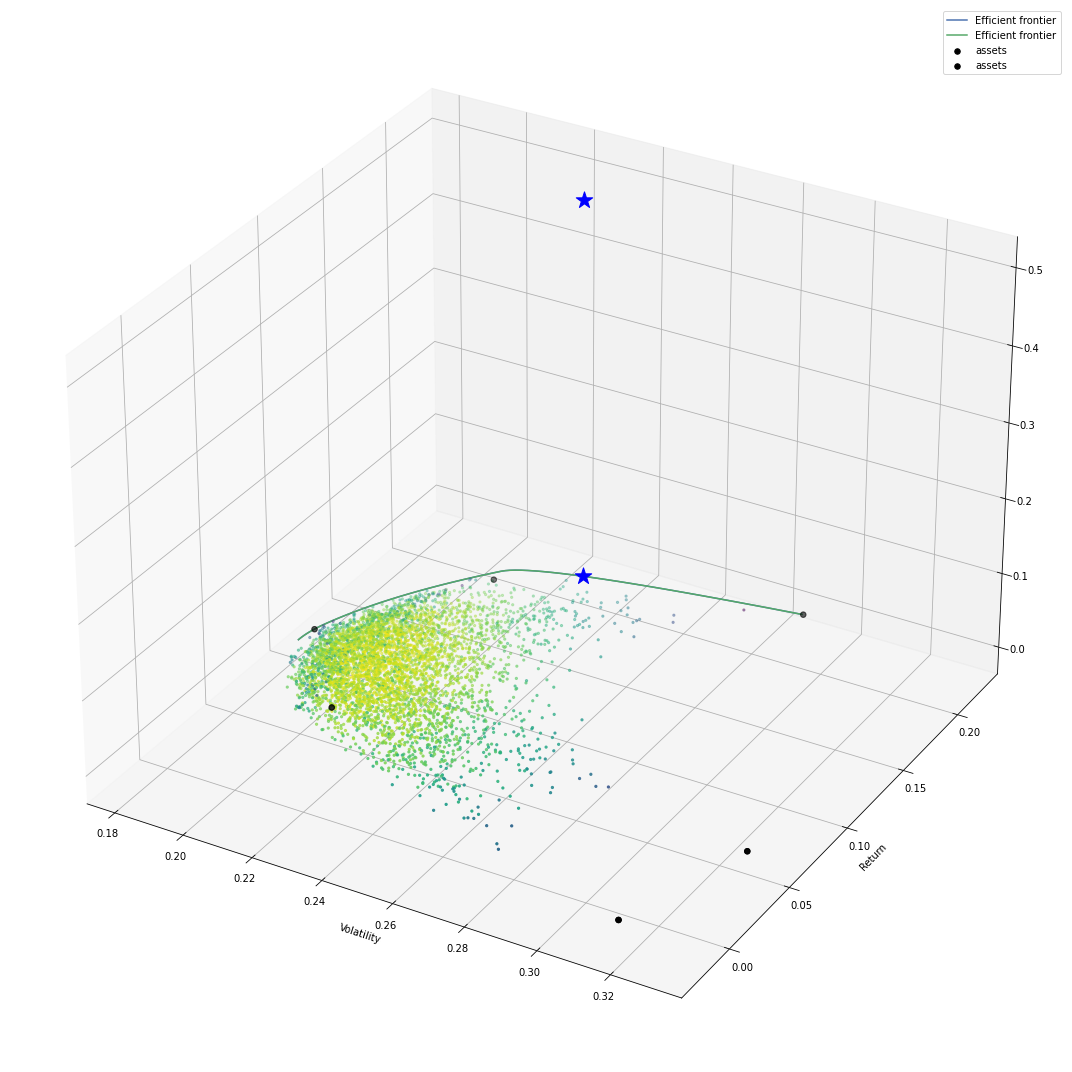

In [62]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks

fig = plt.figure(figsize=(15, 15))
ax= fig.add_subplot(projection='3d')
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)#, ef_param="risk", ef_param_range=np.linspace(0.15,0.2,100))
#plotting.plot_efficient_frontier(ef2, ax=ax, show_assets=True)#, ef_param="risk", ef_param_range=np.linspace(0.1,0.2,100))

# # Generate random portfolios
n_samples = 5000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ Sigma @ w.T))
l_2 = [wx.T@wx for wx in w]
sharpes = rets / stds
ax.scatter3D(stds, rets, 0, marker=".", c=l_2, cmap="viridis_r")
# #ax.plot_surface(stds,rets, l_2, cmap="viridis_r",
#                       # linewidth=0, antialiased=False)

# Find the tangency portfolio
ef.max_sharpe(risk_free_rate=0.1)
ret_tangent, std_tangent, _ = ef.portfolio_performance()
sharpe_pwt=np.array(list(ef.clean_weights().values()))
ax.scatter3D(std_tangent, ret_tangent,(sharpe_pwt.T@sharpe_pwt), s=300, marker="*", c="b", label="Max Sharpe")
ax.scatter3D(std_tangent, ret_tangent, 0, s=300, marker="*", c="b", label="Max Sharpe")

# # Find the L2 portfolio
ef.l2_reg(target_volatility=0.3) 
ret_tangent, std_tangent, _ = ef.portfolio_performance()
l_2_wt = np.array(list(ef.clean_weights().values()))
ax.scatter3D(std_tangent,ret_tangent, (l_2_wt.T@l_2_wt), s=300, marker="+", c="r", label="Max L2")
ax.scatter3D(std_tangent,ret_tangent,  0, s=300, marker="+", c="r", label="Max L2")
print(f'{(l_2_wt.T@l_2_wt)} L2 Norm')
print(std_tangent)

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()

plt.tight_layout()
plt.savefig("ef.png", dpi=200)
plt.show()

In [11]:
l_2_wt

array([0.15982, 0.15187, 0.17711, 0.15835, 0.17497, 0.17788])

In [51]:
ef.__dict__

{'cov_matrix': array([[0.0831793 , 0.04083151, 0.03234212, 0.03788249, 0.03898894,
         0.03582159],
        [0.04083151, 0.10789377, 0.03394736, 0.05182532, 0.03287916,
         0.03495408],
        [0.03234212, 0.03394736, 0.04292196, 0.03072697, 0.03221341,
         0.03254969],
        [0.03788249, 0.05182532, 0.03072697, 0.09992989, 0.0276653 ,
         0.02949831],
        [0.03898894, 0.03287916, 0.03221341, 0.0276653 , 0.04426547,
         0.036123  ],
        [0.03582159, 0.03495408, 0.03254969, 0.02949831, 0.036123  ,
         0.03358345]]),
 'expected_returns': array([ 0.22007963,  0.04694959,  0.05626927, -0.02114668,  0.17948566,
         0.10595668]),
 'n_assets': 6,
 'tickers': ['BSX', 'AES', 'BRK-B', 'SEE', 'QQQ', 'SPY'],
 '_risk_free_rate': 0.1,
 'weights': array([0.5345547, 0.       , 0.       , 0.       , 0.4654453, 0.       ]),
 '_w': Variable((6,)),
 '_objective': Expression(CONVEX, NONNEGATIVE, (1, 1)),
 '_additional_objectives': [],
 '_constraints': [Equality